In [1]:
import json
import pandas as pd
from processing import tokenization_tagging, stopwords_removal, simple_headline_cleaning, analyze_sentiment
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import nltk
import numpy as np
import spacy
from textblob import TextBlob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from wordcloud import WordCloud
import nltk


In [7]:
# Only relevant parts of the training dataset is the text and the rating so we will extract that

review_dict = {
    'reviewText' : [],
    'rating' : []
}

with open("amazonBooks_small_10000_sentiments.json", 'r') as review_json:
    for review in review_json:
        review_dict['reviewText'].append(json.loads(review)['reviewText'])
        review_dict['rating'].append(json.loads(review)['overall'])

sentiments = pd.DataFrame(review_dict)

In [8]:
sentiments.head()

,reviewText,rating
0,"I bought both boxed sets, books 1-5. Really a...",5.0
1,I enjoyed this short book. But it was way way ...,3.0
2,I love Nicholas Sparks. I&#8217;ve read everyt...,4.0
3,I really enjoyed this adventure and look forwa...,4.0
4,It was a decent read.. typical story line. Not...,3.0


In [9]:
# Clean amazon reviewText
sentiments['reviewText'] = sentiments['reviewText'].apply(simple_headline_cleaning)
sentiments['reviewText_lemmatized'] = sentiments['reviewText'].apply(tokenization_tagging)
sentiments['reviewText_cleaned'] = sentiments['reviewText_lemmatized'].apply(stopwords_removal)
sentiments['sentiment'] = sentiments['reviewText_cleaned'].apply(analyze_sentiment)
sentiments.sample(5)

,reviewText,rating,reviewText_lemmatized,reviewText_cleaned,sentiment
8356,story idea good but delivery at times not so m...,3.0,story idea good but delivery at time not so mu...,story idea good delivery time much pull push k...,Positive sentiment
5442,this is a great example of a woman managing di...,5.0,this be a great example of a woman manage dipl...,great example woman manage diplomatically rule...,Positive sentiment
8447,another classic delaware novel i was slightly ...,3.0,another classic delaware novel i be slightly d...,another classic delaware novel slightly disapp...,Negative sentiment
1118,i was afraid this book would be depressing it ...,5.0,i be afraid this book would be depress it wasn...,afraid book would depress wasnt make realize m...,Negative sentiment
5499,omg this book was so good i would intentionall...,5.0,omg this book be so good i would intentionally...,omg book good would intentionally stop reading...,Positive sentiment


In [57]:
#Test positive sentiment analysis 
text = "I am happy"
happy = analyze_sentiment(text)
print(happy)

#Test neutral sentiment analysis 
text = "I am soso"
soso = analyze_sentiment(text)
print(soso)

#Test negative sentiment analysis 
text = "I am sad"
sad = analyze_sentiment(text)
print(sad)


Positive sentiment
Neutral sentiment
Negative sentiment


In [ ]:
#Test sentiment analysis FAIL 
text = "Earthquake hits Singapore. Nobody survived"
nobody_survived = analyze_sentiment(text)
print(nobody_survived)

text = "Earthquake hits Singapore. Nobody died"
nobody_died = analyze_sentiment(text)
print(nobody_died)

In [ ]:
# Data for training classifier 
X = sentiments[['reviewText_cleaned']]
y = sentiments['rating']
print("Shape of X: ", X.shape, "Shape of y: ", y.shape)

In [ ]:
#Train-Test Split for sentiment data
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=0.2)
print ('x_train',x_train.shape, 'x_test',x_test.shape, 'y_train',y_train.shape, 'y_test',y_test.shape)

In [ ]:
# Training the model
vectorizer = CountVectorizer()
matrix_train = vectorizer.fit_transform(x_train['reviewText_cleaned'])

classifier = MultinomialNB()
classifier.fit(matrix_train,y_train)

In [ ]:
# Define the parameter grid to search over
param_grid = {'alpha': np.logspace(-10, 1, 400)}


# Train a Naive Bayes classifier using cross-validation to find the best value of alpha
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(matrix_train, y_train)

# Print the best value of alpha and the corresponding cross-validation score
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Cross-validation score: {grid_search.best_score_:.2f}")

# Evaluate the best classifier on the test data
clf_best = grid_search.best_estimator_
x_test_vect = vectorizer.transform(x_test['reviewText_cleaned'])
accuracy = clf_best.score(x_test_vect, y_test)
print(f"Test accuracy with best alpha: {accuracy:.2f}")

In [11]:
classifier = MultinomialNB(alpha=grid_search.best_params_['alpha'])
classifier.fit(matrix_train,y_train)

MultinomialNB(alpha=0.9548823692395637)

In [12]:
# Evaluating the model
matrix_test = vectorizer.transform(x_test['reviewText_cleaned'])
predicted_results = classifier.predict(matrix_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, predicted_results)
precision = precision_score(y_test, predicted_results, average='weighted', zero_division=0)
recall = recall_score(y_test, predicted_results, average='weighted')
f1 = f1_score(y_test, predicted_results, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.59
Precision: 0.45
Recall: 0.59
F1 score: 0.48


[[   0    0    2    8   46]
 [   0    0    4   16   57]
 [   0    0    1   50  146]
 [   0    0    2   57  460]
 [   0    0    0   32 1119]]


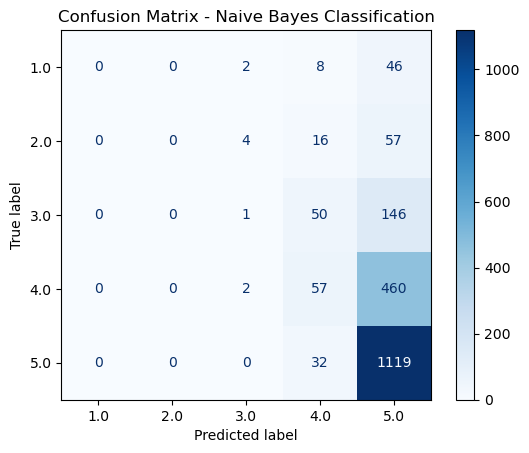

In [13]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predicted_results)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(classifier, matrix_test, y_test,
                                             cmap=plt.cm.Blues,
                                             values_format='')
disp.ax_.set_title('Confusion Matrix - Naive Bayes Classification')

print(disp.confusion_matrix)

plt.show()


In [11]:
# Importing data
def open_file(filepath):
    with open(filepath) as f:
        return json.load(f)
    


In [12]:
kr_asia = open_file("../data_collection/exports/krasia.json")
today = open_file("../data_collection/exports/today.json")
cna = open_file("../data_collection/exports/cna.json")
aseanpost = open_file("../data_collection/exports/asean.json")
bbc = open_file("../data_collection/exports/bbc.json")

In [13]:
news = pd.concat([pd.DataFrame(kr_asia), pd.DataFrame(today), 
                  pd.DataFrame(cna),  pd.DataFrame(aseanpost),  pd.DataFrame(bbc)])
news.head()

,title,url,description,date,category,keywords,source,region
0,Unlocking the Power of ESOPs: Seminar on Attra...,https://kr-asia.com/unlocking-the-power-of-eso...,Learn about the power of ESOPs in attracting t...,2023-04-18T06:14:46+00:00,Events,None,krasia,ASIA
1,Osaka cafe blends real-world and virtual touri...,https://kr-asia.com/osaka-cafe-blends-real-wor...,VR travel's future remains unclear as pandemic...,2023-04-18T04:00:53+00:00,News,None,krasia,ASIA
2,The Uptake | Monday Musings,https://kr-asia.com/the-uptake-monday-musings,"Everything you need to start your week right, ...",2023-04-17T03:00:29+00:00,Newsletters,None,krasia,ASIA
3,ByteDance Launches Fast-Fashion Clothing Store...,https://kr-asia.com/bytedance-launches-fast-fa...,ByteDance joins the fray in the fast-fashion i...,2023-04-18T04:00:14+00:00,News,None,krasia,ASIA
4,"Europe, Japan can help ease rollout of EV batt...",https://kr-asia.com/europe-japan-can-help-ease...,Cooperation is critical to lowering the regula...,2023-04-17T07:18:36+00:00,News,None,krasia,ASIA


In [14]:
## Pre-process titles
news['title'] = news['title'].apply(simple_headline_cleaning)
news['title_lemmatized'] = news['title'].apply(tokenization_tagging)
news['title_cleaned'] = news['title_lemmatized'].apply(stopwords_removal)
news['sentiment'] = news['title_cleaned'].apply(analyze_sentiment)
news.sample(5)

,title,url,description,date,category,keywords,source,region,title_lemmatized,title_cleaned,sentiment
27,todays crises are different,/opinion/2022/jun/17/todays-crises-are-different,"The current climate, health, and food crises s...",2022-06-17T17:59:00+0800,None,"aseanpost, ASEAN Post, The ASEAN Post, theasea...",asean,SEA,today crisis be different,today crisis different,Negative sentiment
8,oneminute world news,/news/10462520,Watch the latest news summary from BBC World N...,2023-04-19 15:21:28,None,[https://static.files.bbci.co.uk/core/website/...,bbc,INTERNATIONAL,oneminute world news,oneminute world news,Neutral sentiment
5,we can end neglected tropical diseases,/opinion/2022/jun/15/we-can-end-neglected-trop...,A new initiative aims to raise awareness and m...,2022-06-15T17:59:00+0800,None,"aseanpost, ASEAN Post, The ASEAN Post, theasea...",asean,SEA,we can end neglected tropical disease,end neglected tropical disease,Negative sentiment
5,hedge fund bfam others file lawsuit against ch...,https://www.channelnewsasia.com/business/hedge...,HONG KONG : Hedge fund BFAM Partners and a few...,2023-04-20T16:24:07+08:00,www.channelnewsasia.com,None,cna,LOCAL,hedge fund bfam others file lawsuit against ch...,hedge fund bfam others file lawsuit chinese de...,Negative sentiment
17,japanese,/japanese/,BBCニュースが伝える世界の動き、BBCニュースならではの視点を日本語でお届けします。世界各...,2023-04-20 00:00:00,None,[],bbc,INTERNATIONAL,japanese,japanese,Neutral sentiment


In [18]:
def word_count(string):
    string = string.split(' ')
    return len(string)

def named_entities_extraction(text):
    nlp = spacy.load("en_core_web_sm")

    # Process the input text with spaCy
    doc = nlp(text)

    # Extract named entities from the document
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    return entities

In [19]:
news['headline_word_count'] = news['title'].apply(word_count)
news['named_entities'] = news['title'].apply(named_entities_extraction)

In [20]:
news.head()

,title,url,description,date,category,keywords,source,region,title_lemmatized,title_cleaned,headline_word_count,named_entities
0,unlocking the power of esops seminar on attrac...,https://kr-asia.com/unlocking-the-power-of-eso...,Learn about the power of ESOPs in attracting t...,2023-04-18T06:14:46+00:00,Events,None,krasia,ASIA,unlock the power of esop seminar on attract to...,unlock power esop seminar attract top talent,10,[]
1,osaka cafe blends realworld and virtual touris...,https://kr-asia.com/osaka-cafe-blends-real-wor...,VR travel's future remains unclear as pandemic...,2023-04-18T04:00:53+00:00,News,None,krasia,ASIA,osaka cafe blend realworld and virtual tourism...,osaka cafe blend realworld virtual tourism hyb...,11,"[(osaka, GPE)]"
2,the uptake monday musings,https://kr-asia.com/the-uptake-monday-musings,"Everything you need to start your week right, ...",2023-04-17T03:00:29+00:00,Newsletters,None,krasia,ASIA,the uptake monday musing,uptake monday musing,5,"[(monday, DATE)]"
3,bytedance launches fastfashion clothing store ...,https://kr-asia.com/bytedance-launches-fast-fa...,ByteDance joins the fray in the fast-fashion i...,2023-04-18T04:00:14+00:00,News,None,krasia,ASIA,bytedance launch fastfashion clothing store on...,bytedance launch fastfashion clothing store do...,8,[]
4,europe japan can help ease rollout of ev batte...,https://kr-asia.com/europe-japan-can-help-ease...,Cooperation is critical to lowering the regula...,2023-04-17T07:18:36+00:00,News,None,krasia,ASIA,europe japan can help ease rollout of ev batte...,europe japan help ease rollout ev battery rule...,12,"[(japan, GPE)]"


In [21]:
## Applying classifier
news_matrix = vectorizer.transform(news['title_cleaned'])
news_results = classifier.predict(news_matrix)
news['rating'] = news_results
news.head()

,title,url,description,date,category,keywords,source,region,title_lemmatized,title_cleaned,headline_word_count,named_entities,rating
0,unlocking the power of esops seminar on attrac...,https://kr-asia.com/unlocking-the-power-of-eso...,Learn about the power of ESOPs in attracting t...,2023-04-18T06:14:46+00:00,Events,None,krasia,ASIA,unlock the power of esop seminar on attract to...,unlock power esop seminar attract top talent,10,[],5.0
1,osaka cafe blends realworld and virtual touris...,https://kr-asia.com/osaka-cafe-blends-real-wor...,VR travel's future remains unclear as pandemic...,2023-04-18T04:00:53+00:00,News,None,krasia,ASIA,osaka cafe blend realworld and virtual tourism...,osaka cafe blend realworld virtual tourism hyb...,11,"[(osaka, GPE)]",4.0
2,the uptake monday musings,https://kr-asia.com/the-uptake-monday-musings,"Everything you need to start your week right, ...",2023-04-17T03:00:29+00:00,Newsletters,None,krasia,ASIA,the uptake monday musing,uptake monday musing,5,"[(monday, DATE)]",5.0
3,bytedance launches fastfashion clothing store ...,https://kr-asia.com/bytedance-launches-fast-fa...,ByteDance joins the fray in the fast-fashion i...,2023-04-18T04:00:14+00:00,News,None,krasia,ASIA,bytedance launch fastfashion clothing store on...,bytedance launch fastfashion clothing store do...,8,[],5.0
4,europe japan can help ease rollout of ev batte...,https://kr-asia.com/europe-japan-can-help-ease...,Cooperation is critical to lowering the regula...,2023-04-17T07:18:36+00:00,News,None,krasia,ASIA,europe japan can help ease rollout of ev batte...,europe japan help ease rollout ev battery rule...,12,"[(japan, GPE)]",5.0


In [22]:
### Create keywords for news articles that don't already have a keyword
## Keywords are created from the headlines

def extract_keywords(text):
    blob = TextBlob(text.lower())
    keywords = [word for word in blob.words if word not in nltk.corpus.stopwords.words('english')]
    return keywords

[nltk_data] Downloading package punkt to /Users/Amirul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
news['keywords'] = news.apply(lambda row: extract_keywords(row['title_cleaned']) if row['keywords'] == None else row['keywords'], axis=1)

In [24]:
news.head()

,title,url,description,date,category,keywords,source,region,title_lemmatized,title_cleaned,headline_word_count,named_entities,rating
0,unlocking the power of esops seminar on attrac...,https://kr-asia.com/unlocking-the-power-of-eso...,Learn about the power of ESOPs in attracting t...,2023-04-18T06:14:46+00:00,Events,"[unlock, power, esop, seminar, attract, top, t...",krasia,ASIA,unlock the power of esop seminar on attract to...,unlock power esop seminar attract top talent,10,[],5.0
1,osaka cafe blends realworld and virtual touris...,https://kr-asia.com/osaka-cafe-blends-real-wor...,VR travel's future remains unclear as pandemic...,2023-04-18T04:00:53+00:00,News,"[osaka, cafe, blend, realworld, virtual, touri...",krasia,ASIA,osaka cafe blend realworld and virtual tourism...,osaka cafe blend realworld virtual tourism hyb...,11,"[(osaka, GPE)]",4.0
2,the uptake monday musings,https://kr-asia.com/the-uptake-monday-musings,"Everything you need to start your week right, ...",2023-04-17T03:00:29+00:00,Newsletters,"[uptake, monday, musing]",krasia,ASIA,the uptake monday musing,uptake monday musing,5,"[(monday, DATE)]",5.0
3,bytedance launches fastfashion clothing store ...,https://kr-asia.com/bytedance-launches-fast-fa...,ByteDance joins the fray in the fast-fashion i...,2023-04-18T04:00:14+00:00,News,"[bytedance, launch, fastfashion, clothing, sto...",krasia,ASIA,bytedance launch fastfashion clothing store on...,bytedance launch fastfashion clothing store do...,8,[],5.0
4,europe japan can help ease rollout of ev batte...,https://kr-asia.com/europe-japan-can-help-ease...,Cooperation is critical to lowering the regula...,2023-04-17T07:18:36+00:00,News,"[europe, japan, help, ease, rollout, ev, batte...",krasia,ASIA,europe japan can help ease rollout of ev batte...,europe japan help ease rollout ev battery rule...,12,"[(japan, GPE)]",5.0


## Description of final table

In [25]:
news.shape

(138, 13)

In [26]:
# Convert the date column to a datetime object and set timezone information
news['date'] = pd.to_datetime(news['date'],utc=True)


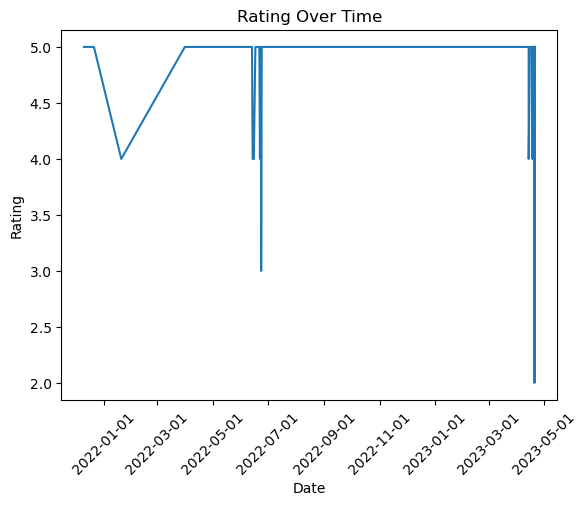

In [27]:
# Create the line chart
# Calculate the median rating for each date
median_ratings = news.groupby('date')['rating'].median()

fig, ax = plt.subplots()
ax.plot(median_ratings.index, median_ratings.values)

# Format the x-axis labels
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45)

# Add axis labels and title
plt.xlabel('Date')
plt.ylabel('Rating')
plt.title('Rating Over Time')

# Show the chart
plt.show()

<AxesSubplot:xlabel='source'>

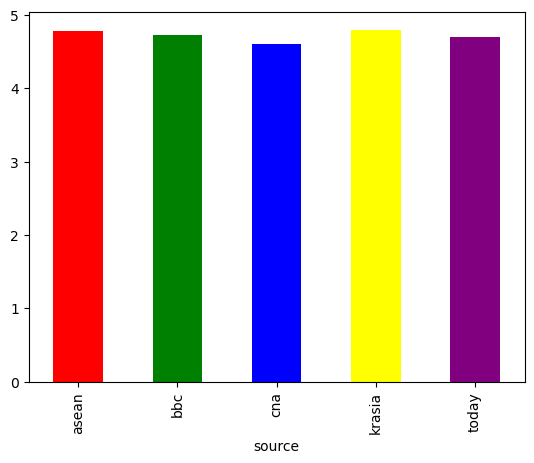

In [28]:
news.groupby('source')['rating'].mean().plot(kind='bar',color=['red','green','blue','yellow','purple'])


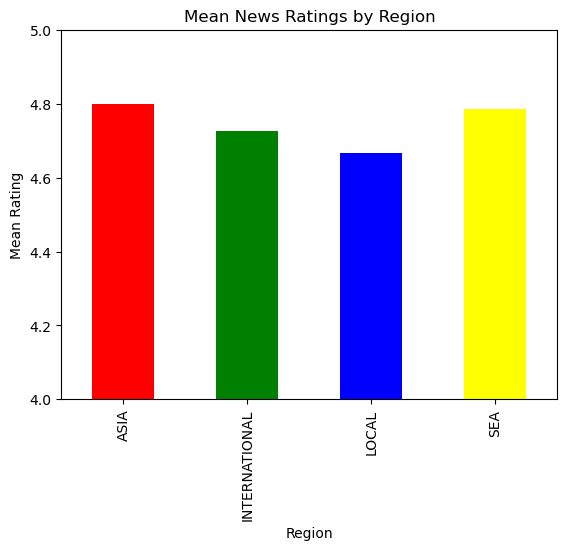

In [29]:

# Group the news DataFrame by region and calculate the mean rating for each group
mean_ratings = news.groupby('region')['rating'].mean()

# Create a bar plot with different colors for each bar
ax = mean_ratings.plot(kind='bar', color=['red', 'green', 'blue', 'yellow', 'purple'])

# Set the y-axis limits between 4 and 5
ax.set_ylim([4, 5])

# Add axis labels and a title
ax.set_xlabel('Region')
ax.set_ylabel('Mean Rating')
ax.set_title('Mean News Ratings by Region')

# Show the plot
plt.show()


In [30]:
# Business function: Filter by keyword
# Allow input for keyword and filter news article that has that word as a keyword

def filter_keyword(keywords, keyword):
    return keyword in keywords

In [31]:
input_value = "Singapore" # Insert input value here
filtered_news = news[news['keywords'].apply(lambda x: filter_keyword(x, input_value))]

filtered_news.head()


,title,url,description,date,category,keywords,source,region,title_lemmatized,title_cleaned,headline_word_count,named_entities,rating
4,ong ye kung rebuts opposition mps says governm...,https://www.channelnewsasia.com/singapore/ong-...,Health Minister Ong Ye Kung said the governmen...,2023-04-20 08:34:00+00:00,www.channelnewsasia.com,"Singapore Parliament,The Workers' Party,Worker...",cna,LOCAL,ong ye kung rebuts opposition mp say governmen...,ong ye kung rebuts opposition mp say governmen...,15,[],4.0


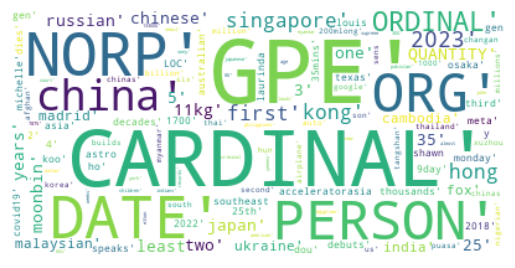

In [43]:
text = " ".join([str(named_entities) for named_entities in news.named_entities])
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()